## Imports

The main thing here is importing all the Tensorflow Keras stuff.
Additionally, scikit-learn is needed to split the data into train/test sets.

In [1]:
import os
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
seed = 0

os.environ['PYTHONHASHSEED'] = str(seed)

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score, precision_score, recall_score, roc_curve, roc_auc_score, \
PrecisionRecallDisplay, RocCurveDisplay
from skmultilearn.model_selection import IterativeStratification

In [5]:
from gensim.models import Word2Vec

In [6]:
sys.path.append("../scripts/")
from ml_utils import MultiLabelClassification

In [7]:
tf.random.set_seed(1)
np.random.seed(1)
random.seed(1)


# session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
# tf.compat.v1.keras.backend.set_session(sess)

## Data preprocessing

In [8]:
df = pd.read_csv("../songs-ml-10pct.csv")

In [9]:
df.lyrics.str.split().apply(len).describe()

count    109817.000000
mean        164.423332
std          82.906356
min           1.000000
25%         109.000000
50%         153.000000
75%         206.000000
max        2392.000000
Name: lyrics, dtype: float64

In [10]:
input_length = df.lyrics.str.split().apply(len).max()
print(input_length)

2392


In [11]:
for col in df.columns[1:]:
    print(f"{col}: {100*df[col].mean():.2g}%")

black: 17%
death: 35%
heavy: 14%
power: 18%
thrash: 16%


In [12]:
X = df.lyrics.values
y = df[df.columns[1:]].values
num_labels = y.shape[1]
labels = df.columns[1:]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(87853,) (21964,) (87853, 5) (21964, 5)


## Text pre-processing

The lyrics are tokenized, then converted into sequences to generate a zero-padded $n$-by-$m$ feature matrix $X$ where $n$ is the number of songs and $m$ is the maximum token length (word count) among songs.

In [14]:
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\r\'')
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.index_word) + 1
print(vocab_size)

139998


In [15]:
def texts_to_sequences(texts, maxlen=input_length):
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=maxlen, padding='post')
    return padded

In [16]:
padded_train = texts_to_sequences(X_train)
padded_test = texts_to_sequences(X_test)

In [17]:
print(padded_train.shape, padded_test.shape)

(87853, 2392) (21964, 2392)


In [18]:
padded_train

array([[   117,      3,     60, ...,      0,      0,      0],
       [  1644,      9,   1054, ...,      0,      0,      0],
       [   204,     10,    288, ...,      0,      0,      0],
       ...,
       [  3203,  18297,   3334, ...,      0,      0,      0],
       [139993,   1070,   4948, ...,      0,      0,      0],
       [     2,    989,    169, ...,      0,      0,      0]])

#### Resize sequences to a more manageable length

In [19]:
# def resize_sequences(X_old, y_old, length):
#     X_new = []
#     y_new = []
#     for i, row in enumerate(X_old):
#         new_rows = np.split(row, np.arange(0, len(row), length))[1:]
#         for new_row in new_rows:
#             new_row_padded = np.pad(new_row, (0, input_length_short - len(new_row)))
#             if sum(new_row_padded) > 0:
#                 X_new.append(new_row_padded)
#                 y_new.append(y_old[i])
#     X_new = np.array(X_new)
#     y_new = np.array(y_new)
#     return X_new, y_new

# input_length_short = 100
# padded_train, y_train = resize_sequences(padded_train, y_train, input_length_short)
# padded_test, y_test = resize_sequences(padded_test, y_test, input_length_short)
# print(padded_train.shape, y_train.shape, padded_test.shape, y_test.shape)

#### Sample weights to deal with imbalanced dataset

In [20]:
# label_weights = 1 / y_train.sum(axis=0)
# label_weights /= label_weights.sum()
# print(label_weights)

# sample_weights = (y_train * label_weights).mean(axis=1)
# sample_weights[sample_weights == 0] = sample_weights.mean()
# for i in range(20):
#     print(y_train[i], sample_weights[i])

## Glove pre-trained word embeddings

#### Load word vectors into a dictionary

Adapted from [a Keras tutorial](https://keras.io/examples/nlp/pretrained_word_embeddings/).

In [21]:
# path_to_glove_file = "E:/Projects/metallyrics/data/glove.840B.300d.txt"
path_to_glove_file = "E:/Projects/metallyrics/data/glove.6B.100d.txt"

embedding_vectors = {}
with open(path_to_glove_file, encoding="utf8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embedding_vectors[word] = coefs
print(len(embedding_vectors))
print(len(list(embedding_vectors.values())[0]))

400001
100


#### Embedding matrix

In [22]:
embedding_dim = len(list(embedding_vectors.values())[0])
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_vectors.get(word)
    if embedding_vector is not None:
        if len(embedding_vector) > 0:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
            continue
    misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 64229 words (75768 misses)


In [23]:
print(embedding_matrix.shape)

(139998, 100)


#### Neural network input embedding layer

In [24]:
embedding_layer = layers.Embedding(
    vocab_size,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

#### Word replacement

In [24]:
# vector = embedding_vectors['satan']
# # dist = np.linalg.norm(embedding_matrix - vector, axis=1)
# dist = -np.dot(embedding_matrix, vector)
# nearest = [(tokenizer.index_word.get(i, 0), dist[i]) for i in  dist.argsort()[1:11]]
# nearest

In [25]:
# from nltk.corpus import stopwords

# ignore = stopwords.words('english')

# np.linalg.norm(embedding_matrix, axis=1)

In [26]:
# def get_nearest_word(word, method='euclidean'):
#     if word not in ignore and isinstance(word, str):
#         if word in embedding_vectors.keys():
#             vector = embedding_vectors[word]
#             if len(vector) > 0:
#                 if method == 'euclidean':
#                     dist = np.linalg.norm(embedding_matrix - vector, axis=1)
#                     i = dist.argsort()[1]
#                 elif method == 'cosine':
#                     embedding_norm = np.linalg.norm(embedding_matrix, axis=1)
#                     vector_norm = np.linalg.norm(vector)
#                     dist = np.dot(embedding_matrix, vector) / (embedding_norm * vector_norm)
#                     dist = np.nan_to_num(dist, 0)
#                     i = dist.argsort()[-2]
#                 else:
#                     assert ValueError(f"invalid method {method}")
#                 nearest = tokenizer.index_word.get(i, 0)
#                 if nearest not in ignore:
#                     return nearest
#     return word

# words = [tokenizer.index_word.get(i, 0) for i in padded_train[111]]
# new_words = [get_nearest_word(word, 'cosine') for word in words]
# new_row = [tokenizer.word_index.get(word, 0) for word in new_words]
# print(words[:20])
# print(new_words[:20])

## Baseline convolutional neural network (single-label)

We start with a baseline model trained on a single output label.
Death metal is the least imbalanced label, appearing in about a third of samples,
so it's a good first choice just to approach the problem as a standard binary classification problem.
Best to keep this baseline as simple as possible,
so no fancy architecture beyond a single convolutional layer and a full-connected layer.

A few notes on the parameters:
* The embedding layer dimensions have already been set above,
  so this will probably stay untouched from here on:
  * input shape = (sequence length) * (vocab size) = 2,392 * 139,998 ~ 334,875,216
  * output shape = (sequence length) * (embedding dimension) = 2,392 * 100 = 239,200
* The convolutional layer has 128 filters,
  maybe a bit large to start with but the sequence length is very large,
  so it seems appropriate. Starting with a kernel size of 4 for now.
* Global maximum pooling is a common choice in NLP for some reason.
* After global max pooling, we get a number of outputs equal to the number of filters, 128.
  Typically the final fully connected layer can be anywhere between the number of inputs and outputs,
  so somewhere right between 128 and 1 (for single-label binary classification) will do.
  I've gone with 32.
* An Adam optimizer with a learning rate of $1 \times 10^4$ is a common starting point.
  As it's a binary classification problem, binary crossentropy is the go-to loss function
  and accuracy is the only metric we'll need.

In [48]:
def create_baseline_model(bias_initializer=None):
    model = Sequential()
    model.add(embedding_layer)
    model.add(layers.Conv1D(filters=128, kernel_size=4, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Flatten())
    model.add(layers.Dense(32))
    if bias_initializer is not None:
        model.add(layers.Dense(1, activation='sigmoid', bias_initializer=bias_initializer))
    else:
        model.add(layers.Dense(1, activation='sigmoid'))
    opt = Adam(learning_rate=1e-4)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [27]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
    ax1.plot(history['accuracy'])
    ax1.plot(history['val_accuracy'])
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'validation'], loc='upper left')
    ax2.plot(history['loss'])
    ax2.plot(history['val_loss'])
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    plt.show()

#### Setting a better initial bias to account for label imbalance

With the default initialization of neural network parametrs,
the model won't make predictions that scale appropriately with the probability of positive cases.
If only a third of samples are positive, an untrained model should output prediction probabilities close to one-third.
We can check this by evaluating the untrained model and checking its loss on the training set.
Following the advice of [this tutorial](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#optional_set_the_correct_initial_bias),
we can explicitly initialize the model with a bias of $\log(n_1, n_0)$,
where $n_1$ and $n_0$ are the number of positives and negatives,
resulting in a initial loss is closer to the expected value of $-p \log(p) - (1 - p) \log(1 - p) \approx 0.65$.

In [49]:
p = y_train[:, 1].mean()
-p * np.log(p) - (1 - p) * np.log(1 - p)

0.6482004788134439

In [50]:
cnn_model = create_baseline_model()
print(cnn_model.summary())

cnn_pred = cnn_model.predict(padded_test[:10])
cnn_loss, cnn_acc = cnn_model.evaluate(padded_train, y_train[:, 1], verbose=0)

print("Initial prediction:")
print(cnn_pred)
print(f"Initial loss: {cnn_loss:.4f}")
print(f"Initial accuracy: {cnn_acc:.4f}")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         13999800  
                                                                 
 conv1d_7 (Conv1D)           (None, None, 128)         51328     
                                                                 
 global_max_pooling1d_4 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 flatten_3 (Flatten)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 32)                4128      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                      

In [51]:
neg, pos = np.bincount(y_train[:, 1])
init_bias = np.log(pos / neg)
print(f"New initial bias: {init_bias:.4f}")
bias_initializer = keras.initializers.Constant(np.log([pos / neg]))

New initial bias: -0.6137


In [52]:
cnn_model = create_baseline_model(bias_initializer=bias_initializer)
print(cnn_model.summary())

cnn_pred = cnn_model.predict(padded_test[:10])
cnn_loss, cnn_acc = cnn_model.evaluate(padded_train, y_train[:, 1], verbose=0)

print("Initial prediction:")
print(cnn_pred)
print(f"Initial loss: {cnn_loss:.4f}")
print(f"Initial accuracy: {cnn_acc:.4f}")

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         13999800  
                                                                 
 conv1d_8 (Conv1D)           (None, None, 128)         51328     
                                                                 
 global_max_pooling1d_5 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 flatten_4 (Flatten)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 32)                4128      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                      

In [53]:
cnn_model.save_weights('initial_weights.h5')

In [54]:
# cnn_model = Sequential()
# cnn_model.add(embedding_layer)
# cnn_model.add(layers.Conv1D(filters=128, kernel_size=4, activation='relu'))
# # cnn_model.add(layers.BatchNormalization())
# # cnn_model.add(layers.MaxPooling1D(pool_size=2))
# # cnn_model.add(layers.Conv1D(filters=64, kernel_size=4, activation='relu'))
# # cnn_model.add(layers.BatchNormalization())
# cnn_model.add(layers.GlobalMaxPooling1D())
# cnn_model.add(layers.Flatten())
# cnn_model.add(layers.Dense(256))
# cnn_model.add(layers.Dense(1, activation='sigmoid'))
# # cnn_model.add(layers.Dense(num_labels, activation='sigmoid'))
# opt = Adam(learning_rate=1e-4)
# cnn_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
# print(cnn_model.summary())

#### Train on small batch

At this point we can start training on a small subset to see if the baseline learns at all. It should demonstrate some minor improvement in accuracy and reduction in loss compared to the initialize performance. It should also overfit due to the limited training set.

In [55]:
cnn_model = create_baseline_model(bias_initializer=bias_initializer)
print(cnn_model.summary())

cnn_history = cnn_model.fit(padded_train[::100], y_train[::100, 1], epochs=32, batch_size=32, validation_split=0.2, verbose=2)
cnn_pred = cnn_model.predict(padded_test)
cnn_loss, cnn_acc = cnn_model.evaluate(padded_test, y_test[:, 1], verbose=0)
print(f"loss: {cnn_loss:.4f}\nacc: {cnn_acc:.4f}")

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         13999800  
                                                                 
 conv1d_9 (Conv1D)           (None, None, 128)         51328     
                                                                 
 global_max_pooling1d_6 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 flatten_5 (Flatten)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 32)                4128      
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                      

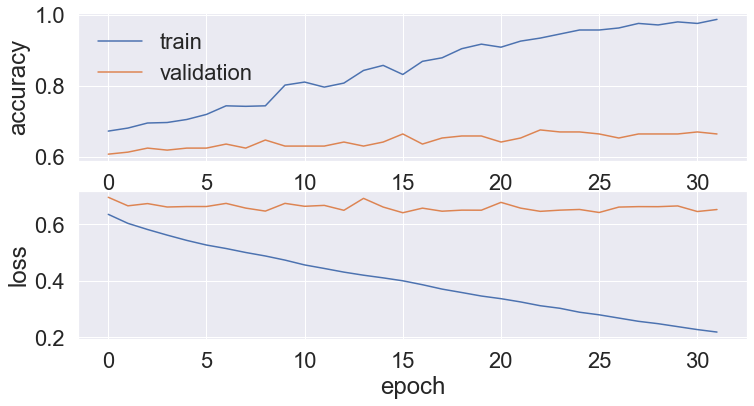

In [56]:
plot_history(cnn_history.history)

The test and validation accuracy indeed improved over the untrained model, so the fitting process is working.
It's also overfitting, as seen in the training metrics outperforming the validation ones.

#### Train on larger batch

Now we can expand to a five times larger training set,
to check that more data results in better fitting.
Particularly we can expect less overfitting when training on more data,
since the larger training set provides broader exposure to the feature space.

In [57]:
cnn_model = create_baseline_model(bias_initializer=bias_initializer)
print(cnn_model.summary())

cnn_history = cnn_model.fit(padded_train[::20], y_train[::20, 1], epochs=32, batch_size=32, validation_split=0.2, verbose=2)
cnn_pred = cnn_model.predict(padded_test)
cnn_loss, cnn_acc = cnn_model.evaluate(padded_test, y_test[:, 1], verbose=0)
print(f"loss: {cnn_loss:.4f}\nacc: {cnn_acc:.4f}")

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         13999800  
                                                                 
 conv1d_10 (Conv1D)          (None, None, 128)         51328     
                                                                 
 global_max_pooling1d_7 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 flatten_6 (Flatten)         (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 32)                4128      
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                      

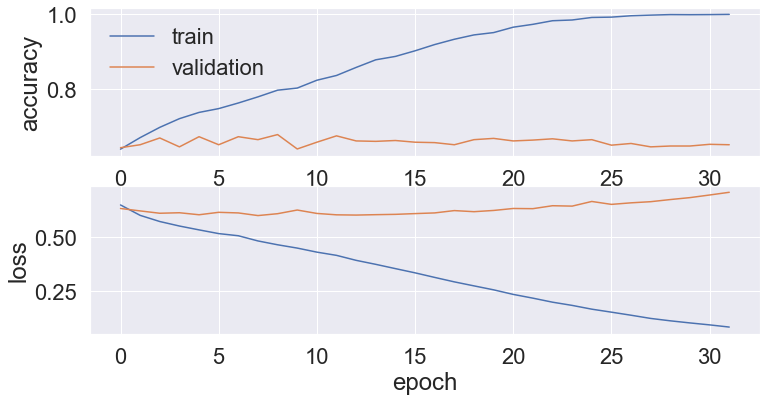

In [58]:
plot_history(cnn_history.history)

The training metrics initially show slower improvement over the same number of epochs.
This is because the model is taking longer to train on a more generalized dataset.
The validation metrics show better generalizability, particularly early on, as well.
The model likely started to overtrain, resulting in a drop and plateau in validation accuracy.

#### Evaluation metrics

Before scaling up and tuning hyperparameters, it'll be worthwhile to develop some more helpful metrics to evaluate performance.

In [25]:
def plot_cm(true, pred, p=0.5):
    cm = confusion_matrix(true, pred > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    print('True Negatives: ', cm[0][0])
    print('False Positives: ', cm[0][1])
    print('False Negatives: ', cm[1][0])
    print('True Positives: ', cm[1][1])
    print('Positives: ', np.sum(cm[1]))
    return cm

True Negatives:  11652
False Positives:  2406
False Negatives:  4841
True Positives:  3065
Positives:  7906


array([[11652,  2406],
       [ 4841,  3065]], dtype=int64)

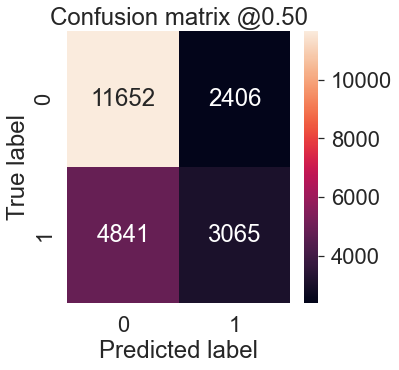

In [60]:
plot_cm(y_test[:, 1], cnn_pred.flatten())

There are more true positives and negatives than false positives and negatives, respectively,
so it's doing better than random guessing so far.

In [26]:
def plot_curves(true, pred):
    fpr, tpr, _ = roc_curve(true, pred)
    print(roc_auc_score(true, pred))
    roc_disp = RocCurveDisplay(fpr=fpr, tpr=tpr)
    prec, rec, _ = precision_recall_curve(true, pred)
    pr_disp = PrecisionRecallDisplay(prec, rec)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    roc_disp.plot(ax=ax1, label="ROC curve")
    pr_disp.plot(ax=ax2)
    ax1.plot([0, 1], [0, 1], 'k--', label="Random classifier")
    ax1.set_xlim(0, 1)
    ax2.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    ax2.set_ylim(0, 1)
    ax1.legend()
    plt.show()

0.6898297041021589


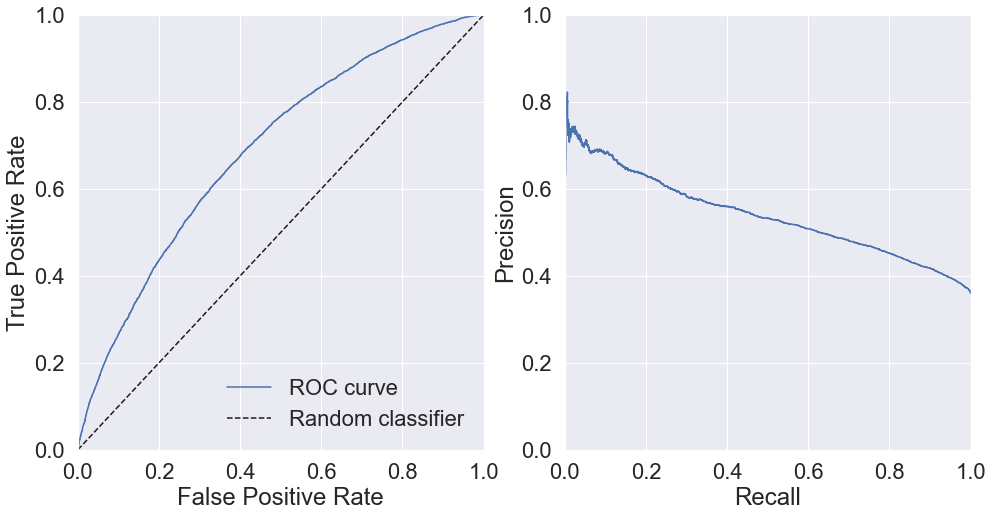

In [62]:
plot_curves(y_test[:, 1], cnn_pred.flatten())

The receiver operating characteristic (ROC) curve also shows the model outperforming random guessing;
a perfect classifier would pull the curve completely to the top right
(maximizing the ratio of true positive rate to false positive rate).
The precision-recall curve shows poor precision at low threshold.

#### Train on (almost) full dataset

The goal now is to intentionally overfit to the full training set
before making tweaks to regularize for generalizability.

In [63]:
cnn_model = create_baseline_model(bias_initializer=bias_initializer)
print(cnn_model.summary())

cnn_history = cnn_model.fit(padded_train[::3], y_train[::3, 1], epochs=32, batch_size=32, validation_split=0.2, verbose=1)
cnn_pred = cnn_model.predict(padded_test)
cnn_loss, cnn_acc = cnn_model.evaluate(padded_test, y_test[:, 1], verbose=0)
print(f"loss: {cnn_loss:.4f}\nacc: {cnn_acc:.4f}")

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         13999800  
                                                                 
 conv1d_11 (Conv1D)          (None, None, 128)         51328     
                                                                 
 global_max_pooling1d_8 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 flatten_7 (Flatten)         (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 32)                4128      
                                                                 
 dense_15 (Dense)            (None, 1)                 33        
                                                      

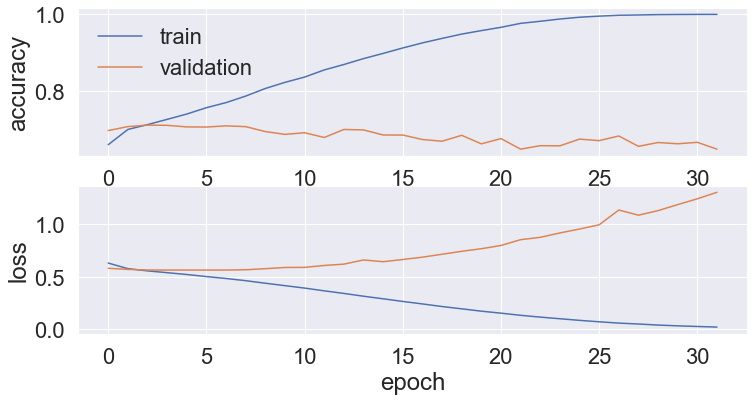

In [64]:
plot_history(cnn_history.history)

0.6644761644298456


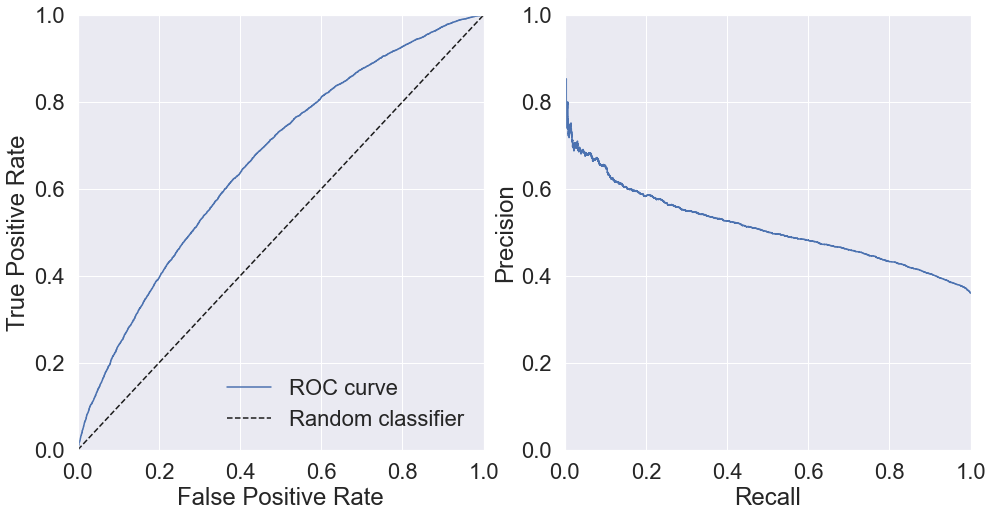

In [65]:
plot_curves(y_test[:, 1], cnn_pred.flatten())

The model is clearly capable of overfitting to the training data.
The training accuracy converges to 100% quite quickly,
so now we know the basic training pipeline is working as desired.
The goal now is to continue building a stronger model while adding regularization methods

## Regularization and learning rates

#### Add batch normalization

To see if regularization reduces overfitting on the baseline,
we can simply add a batch normalization after the one convolutional layer.
This normalizes the inputs to the next layer each batch, fixing such that they have zero mean and unit variance.

In [66]:
def create_model(bias_initializer=None):
    model = Sequential()
    model.add(embedding_layer)
    model.add(layers.Conv1D(filters=128, kernel_size=4, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Flatten())
    model.add(layers.Dense(32))
    if bias_initializer is not None:
        model.add(layers.Dense(1, activation='sigmoid', bias_initializer=bias_initializer))
    else:
        model.add(layers.Dense(1, activation='sigmoid'))
    opt = Adam(learning_rate=1e-4)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [67]:
cnn_model = create_model(bias_initializer=bias_initializer)
print(cnn_model.summary())

cnn_history = cnn_model.fit(padded_train[::3], y_train[::3, 1], epochs=32, batch_size=32, validation_split=0.2, verbose=1)
cnn_pred = cnn_model.predict(padded_test)
cnn_loss, cnn_acc = cnn_model.evaluate(padded_test, y_test[:, 1], verbose=0)
print(f"loss: {cnn_loss:.4f}\nacc: {cnn_acc:.4f}")

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         13999800  
                                                                 
 conv1d_12 (Conv1D)          (None, None, 128)         51328     
                                                                 
 batch_normalization (BatchN  (None, None, 128)        512       
 ormalization)                                                   
                                                                 
 global_max_pooling1d_9 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 flatten_8 (Flatten)         (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 32)               

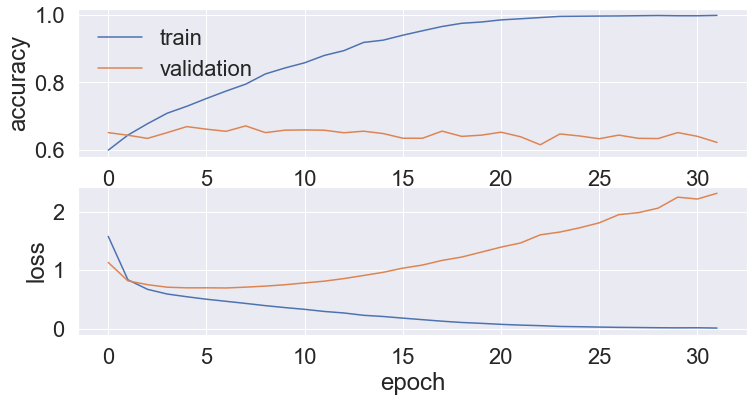

In [68]:
plot_history(cnn_history.history)

0.6421705394049451


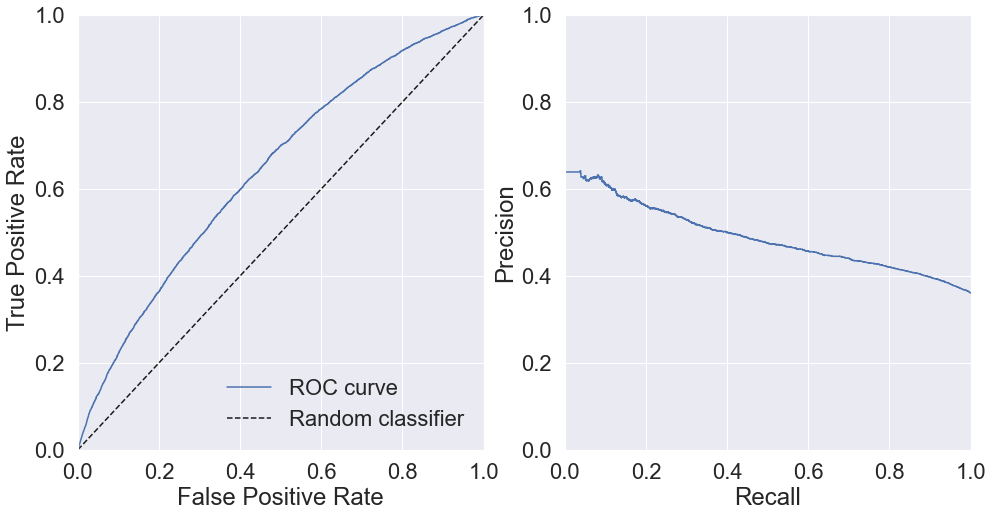

In [69]:
plot_curves(y_test[:, 1], cnn_pred.flatten())

#### Different learning rates

So far I've used a learning rate of $1\times 10^{-4}$.
This could be too high given the validation metrics start to diverge after just a few epochs.
Here I try dropping it by about a third.

In [70]:
def create_model(batch_norm=False, bias_initializer=None, learning_rate=1e-4):
    model = Sequential()
    model.add(embedding_layer)
    model.add(layers.Conv1D(filters=128, kernel_size=4, activation='relu'))
    if batch_norm:
        model.add(layers.BatchNormalization())
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Flatten())
    model.add(layers.Dense(32))
    if bias_initializer is not None:
        model.add(layers.Dense(1, activation='sigmoid', bias_initializer=bias_initializer))
    else:
        model.add(layers.Dense(1, activation='sigmoid'))
    opt = Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [71]:
cnn_model = create_model(
    batch_norm=False,
    bias_initializer=bias_initializer,
    learning_rate=3e-5
)
print(cnn_model.summary())

cnn_history = cnn_model.fit(padded_train[::3], y_train[::3, 1], epochs=16, batch_size=32, validation_split=0.2, verbose=1)
cnn_pred = cnn_model.predict(padded_test)
cnn_loss, cnn_acc = cnn_model.evaluate(padded_test, y_test[:, 1], verbose=0)
print(f"loss: {cnn_loss:.4f}\nacc: {cnn_acc:.4f}")

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         13999800  
                                                                 
 conv1d_13 (Conv1D)          (None, None, 128)         51328     
                                                                 
 global_max_pooling1d_10 (Gl  (None, 128)              0         
 obalMaxPooling1D)                                               
                                                                 
 flatten_9 (Flatten)         (None, 128)               0         
                                                                 
 dense_18 (Dense)            (None, 32)                4128      
                                                                 
 dense_19 (Dense)            (None, 1)                 33        
                                                     

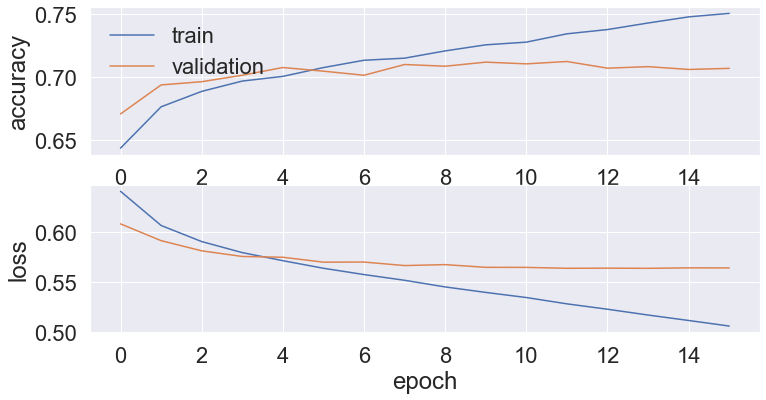

In [72]:
plot_history(cnn_history.history)

True Negatives:  12205
False Positives:  1853
False Negatives:  4968
True Positives:  2938
Positives:  7906


array([[12205,  1853],
       [ 4968,  2938]], dtype=int64)

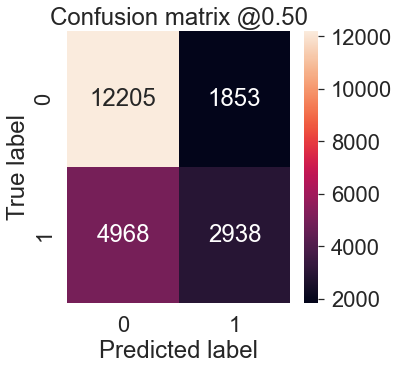

In [73]:
plot_cm(y_test[:, 1], cnn_pred.flatten())

0.7222937114956192


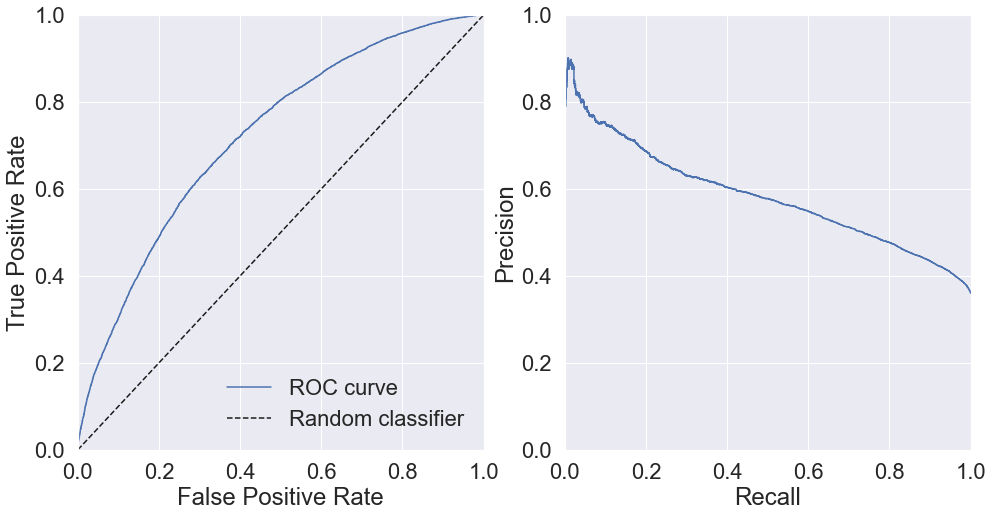

In [74]:
plot_curves(y_test[:, 1], cnn_pred.flatten())

Now adding batch normalization:

In [75]:
cnn_model = create_model(
    batch_norm=True,
    bias_initializer=bias_initializer,
    learning_rate=3e-5
)
print(cnn_model.summary())

cnn_history = cnn_model.fit(padded_train[::3], y_train[::3, 1], epochs=16, batch_size=32, validation_split=0.2, verbose=1)
cnn_pred = cnn_model.predict(padded_test)
cnn_loss, cnn_acc = cnn_model.evaluate(padded_test, y_test[:, 1], verbose=0)
print(f"loss: {cnn_loss:.4f}\nacc: {cnn_acc:.4f}")

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         13999800  
                                                                 
 conv1d_14 (Conv1D)          (None, None, 128)         51328     
                                                                 
 batch_normalization_1 (Batc  (None, None, 128)        512       
 hNormalization)                                                 
                                                                 
 global_max_pooling1d_11 (Gl  (None, 128)              0         
 obalMaxPooling1D)                                               
                                                                 
 flatten_10 (Flatten)        (None, 128)               0         
                                                                 
 dense_20 (Dense)            (None, 32)              

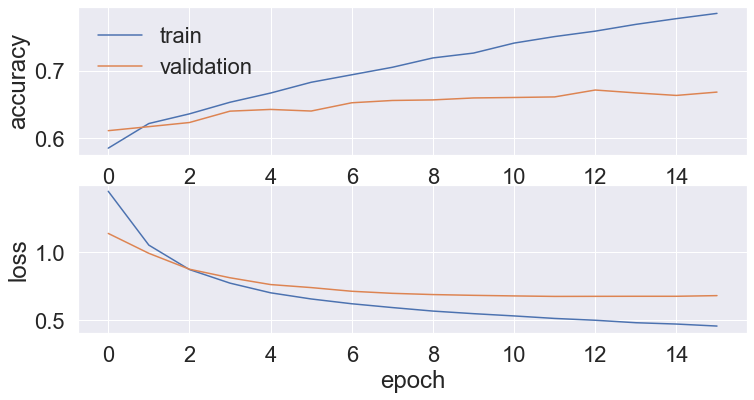

In [76]:
plot_history(cnn_history.history)

True Negatives:  11240
False Positives:  2818
False Negatives:  4778
True Positives:  3128
Positives:  7906


array([[11240,  2818],
       [ 4778,  3128]], dtype=int64)

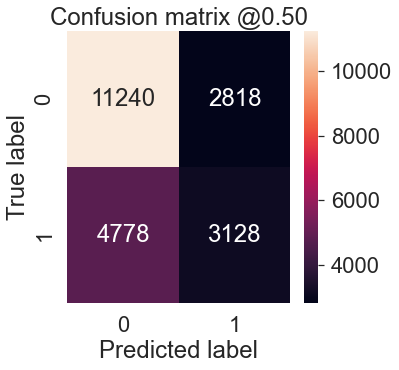

In [77]:
plot_cm(y_test[:, 1], cnn_pred.flatten())

0.660652984129894


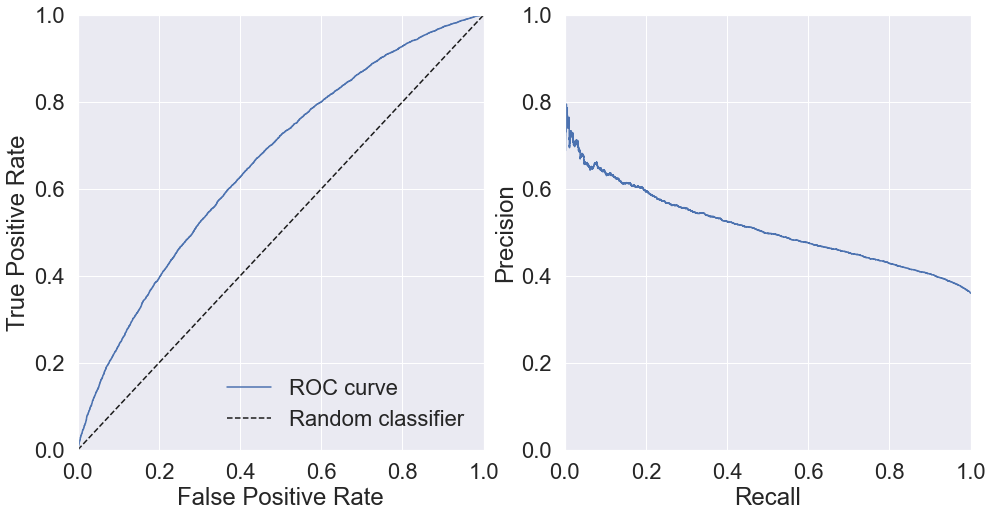

In [78]:
plot_curves(y_test[:, 1], cnn_pred.flatten())

## Increasing model complexity

Even with batch normalization the model isn't doing so well generalizing.
Given the size of feature space the model may be too simple for the task.
We can increase the complexity of the model in two ways:

* Width: increasing the number of filters in the convolutional layer.
* Depth: adding more convolutional layers.

In [79]:
def create_model(num_conv_layers=1, filters=128, batch_norm=False, bias_initializer=None, learning_rate=1e-4):
    model = Sequential()
    model.add(embedding_layer)
    for _ in range(num_conv_layers):
        model.add(layers.Conv1D(filters=filters, kernel_size=4, activation='relu'))
        if batch_norm:
            model.add(layers.BatchNormalization())
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Flatten())
    model.add(layers.Dense(32))
    if bias_initializer is not None:
        model.add(layers.Dense(1, activation='sigmoid', bias_initializer=bias_initializer))
    else:
        model.add(layers.Dense(1, activation='sigmoid'))
    opt = Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

#### More filters

Let's try scaling in width first, by doubling the filters.

In [80]:
cnn_model = create_model(
    num_conv_layers=1,
    filters=256,
    batch_norm=False,
    bias_initializer=bias_initializer,
    learning_rate=3e-5
)
print(cnn_model.summary())

cnn_history = cnn_model.fit(padded_train[::3], y_train[::3, 1], epochs=16, batch_size=32, validation_split=0.2, verbose=1)
cnn_pred = cnn_model.predict(padded_test)
cnn_loss, cnn_acc = cnn_model.evaluate(padded_test, y_test[:, 1], verbose=0)
print(f"loss: {cnn_loss:.4f}\nacc: {cnn_acc:.4f}")

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         13999800  
                                                                 
 conv1d_15 (Conv1D)          (None, None, 256)         102656    
                                                                 
 global_max_pooling1d_12 (Gl  (None, 256)              0         
 obalMaxPooling1D)                                               
                                                                 
 flatten_11 (Flatten)        (None, 256)               0         
                                                                 
 dense_22 (Dense)            (None, 32)                8224      
                                                                 
 dense_23 (Dense)            (None, 1)                 33        
                                                     

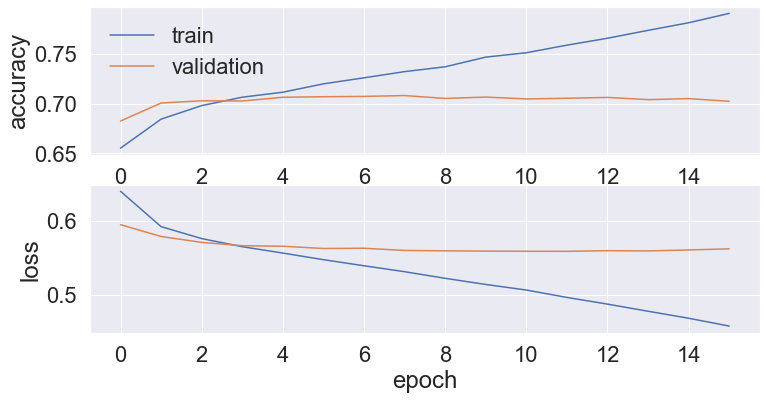

In [81]:
plot_history(cnn_history.history)

True Negatives:  11562
False Positives:  2496
False Negatives:  4314
True Positives:  3592
Positives:  7906


array([[11562,  2496],
       [ 4314,  3592]], dtype=int64)

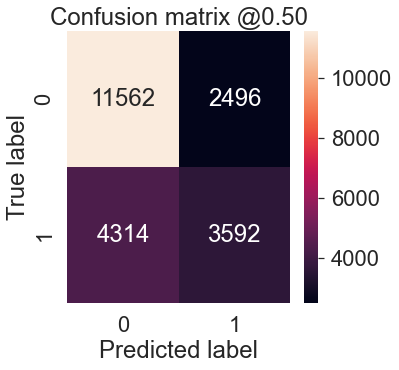

In [82]:
plot_cm(y_test[:, 1], cnn_pred.flatten())

0.7263415042455208


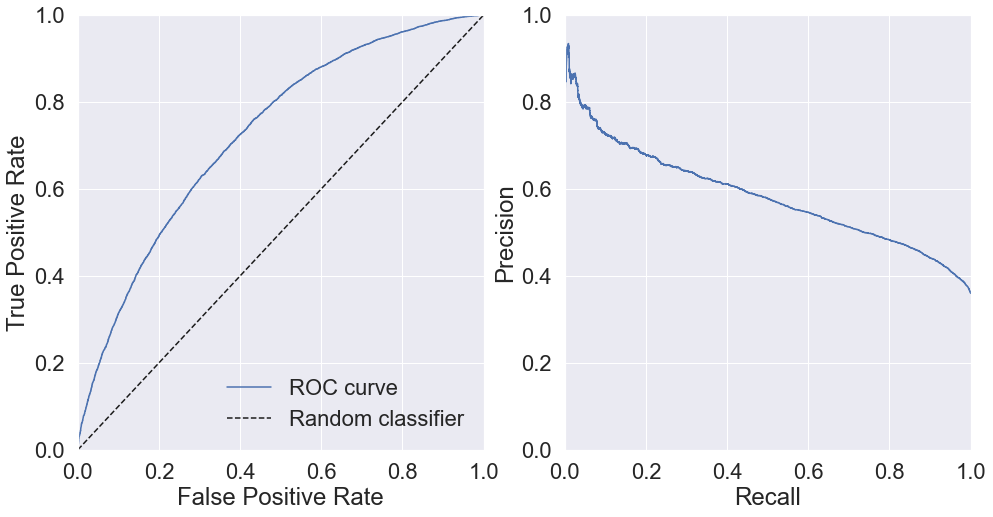

In [83]:
plot_curves(y_test[:, 1], cnn_pred.flatten())

#### More layers

Not bad! Now let's try doubling depth instead.

In [84]:
cnn_model = create_model(
    num_conv_layers=2,
    filters=128,
    batch_norm=False,
    bias_initializer=bias_initializer,
    learning_rate=3e-5
)
print(cnn_model.summary())

cnn_history = cnn_model.fit(padded_train[::3], y_train[::3, 1], epochs=16, batch_size=32, validation_split=0.2, verbose=1)
cnn_pred = cnn_model.predict(padded_test)
cnn_loss, cnn_acc = cnn_model.evaluate(padded_test, y_test[:, 1], verbose=0)
print(f"loss: {cnn_loss:.4f}\nacc: {cnn_acc:.4f}")

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         13999800  
                                                                 
 conv1d_16 (Conv1D)          (None, None, 128)         51328     
                                                                 
 conv1d_17 (Conv1D)          (None, None, 128)         65664     
                                                                 
 global_max_pooling1d_13 (Gl  (None, 128)              0         
 obalMaxPooling1D)                                               
                                                                 
 flatten_12 (Flatten)        (None, 128)               0         
                                                                 
 dense_24 (Dense)            (None, 32)                4128      
                                                     

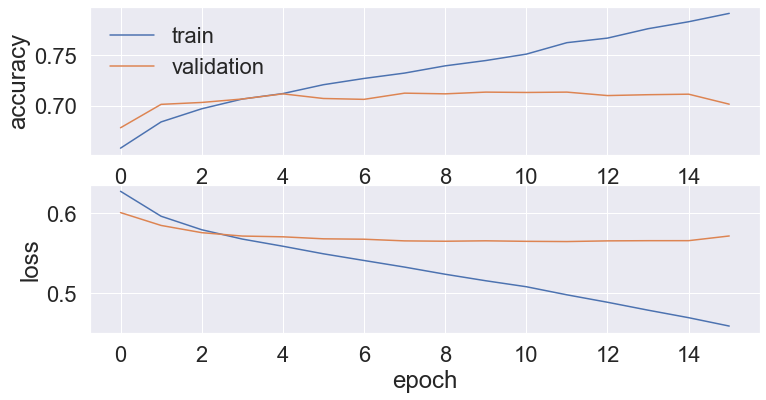

In [85]:
plot_history(cnn_history.history)

True Negatives:  11044
False Positives:  3014
False Negatives:  3942
True Positives:  3964
Positives:  7906


array([[11044,  3014],
       [ 3942,  3964]], dtype=int64)

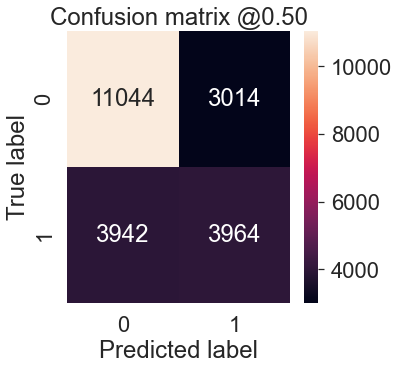

In [86]:
plot_cm(y_test[:, 1], cnn_pred.flatten())

0.719777244984522


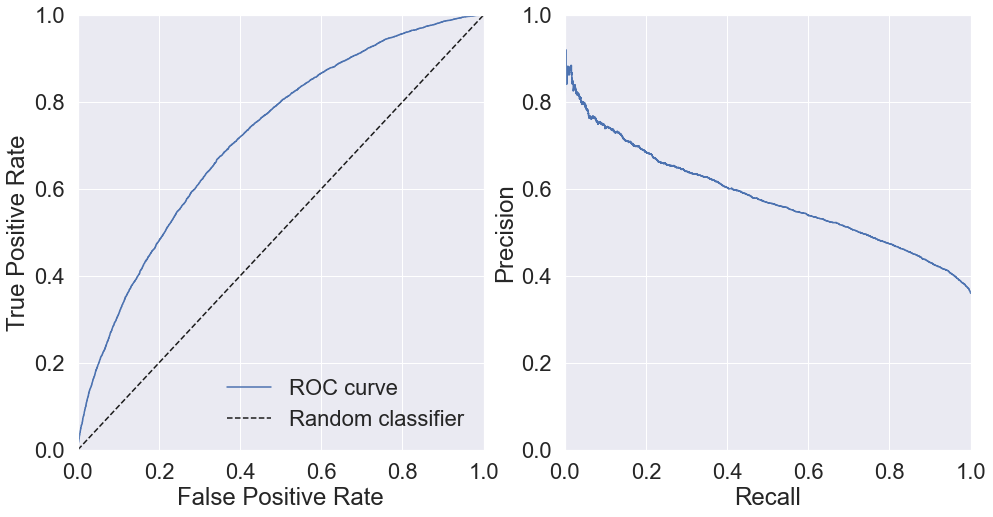

In [87]:
plot_curves(y_test[:, 1], cnn_pred.flatten())

## Early stopping callback

In [68]:
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        min_delta=0,
        patience=10,
        verbose=0,
        mode="auto",
        baseline=None,
        restore_best_weights=False,
    )
]

## LSTM - Single-label

In [30]:
def create_lstm(units=128, batch_norm=False, bias_initializer=None, learning_rate=1e-4):
    model = Sequential()
    model.add(embedding_layer)
    model.add(layers.SpatialDropout1D(0.2))
    model.add(layers.Bidirectional(layers.LSTM(units, return_sequences=False)))
    model.add(layers.Dropout(0.2))
    model.add(layers.BatchNormalization())
    if bias_initializer is not None:
        model.add(layers.Dense(1, activation='sigmoid', bias_initializer=bias_initializer))
    else:
        model.add(layers.Dense(1, activation='sigmoid'))
    opt = Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    print(model.summary())
    return model

#### Small batch

In [ ]:
lstm_model = create_lstm(
    units=128,
    batch_norm=False,
    bias_initializer=None,
    learning_rate=1e-4
)
lstm_history = lstm_model.fit(padded_train[::100], y_train[::100, 1], epochs=16, batch_size=32, validation_split=0.2, verbose=1)
lstm_pred = lstm_model.predict(padded_test)
lstm_loss, lstm_acc = lstm_model.evaluate(padded_test, y_test[:, 1], verbose=0)
print(f"loss: {lstm_loss:.4f}\nacc: {lstm_acc:.4f}")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         13999800  
                                                                 
 spatial_dropout1d_1 (Spatia  (None, None, 100)        0         
 lDropout1D)                                                     
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              234496    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                      

In [ ]:
lstm_loss, lstm_acc = lstm_model.evaluate(padded_test, y_test[:, 1], verbose=0)
print(f"loss: {lstm_loss:.4f}\nacc: {lstm_acc:.4f}")

In [ ]:
plot_history(lstm_history.history)

In [ ]:
plot_cm(y_test[:, 1], lstm_pred.flatten())

In [ ]:
plot_curves(y_test[:, 1], lstm_pred.flatten())

#### Large batch

In [ ]:
lstm_model = create_lstm(
    units=128,
    batch_norm=False,
    bias_initializer=None,
    learning_rate=1e-4
)
lstm_history = lstm_model.fit(padded_train[::20], y_train[::20, 1], epochs=16, batch_size=32, validation_split=0.2, verbose=1)
lstm_pred = lstm_model.predict(padded_test)
lstm_loss, lstm_acc = lstm_model.evaluate(padded_test, y_test[:, 1], verbose=0)
print(f"loss: {lstm_loss:.4f}\nacc: {lstm_acc:.4f}")

In [ ]:
plot_history(lstm_history.history)

In [ ]:
plot_cm(y_test[:, 1], lstm_pred.flatten())

In [ ]:
plot_curves(y_test[:, 1], lstm_pred.flatten())

## LSTM - Multi-label

In [35]:
lstm_model = Sequential()
lstm_model.add(embedding_layer)
lstm_model.add(layers.SpatialDropout1D(0.2))
lstm_model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=False)))
lstm_model.add(layers.Dropout(0.2))
lstm_model.add(layers.BatchNormalization())
lstm_model.add(layers.Dense(num_labels, activation='sigmoid'))
opt = Adam(learning_rate=0.001)
lstm_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
print(lstm_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         9570000   
                                                                 
 spatial_dropout1d (SpatialD  (None, None, 100)        0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 256)              234496    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                      

In [36]:
lstm_history = lstm_model.fit(padded_train, y_train, epochs=64, batch_size=32, validation_split=0.2, verbose=1)
lstm_pred = lstm_model.predict(padded_test)
lstm_loss, lstm_acc = lstm_model.evaluate(padded_test, y_test, verbose=0)
print(f"loss: {lstm_loss:.4f}\nacc: {lstm_acc:.4f}")

Epoch 1/64
2580/2580 [==============================] - 125s 48ms/step - loss: 0.4844 - accuracy: 0.3388 - val_loss: 0.4449 - val_accuracy: 0.3795
Epoch 2/64
2580/2580 [==============================] - 131s 51ms/step - loss: 0.4490 - accuracy: 0.3805 - val_loss: 0.4387 - val_accuracy: 0.3953
Epoch 3/64
2580/2580 [==============================] - 134s 52ms/step - loss: 0.4407 - accuracy: 0.3966 - val_loss: 0.4341 - val_accuracy: 0.3836
Epoch 4/64
2580/2580 [==============================] - 150s 58ms/step - loss: 0.4338 - accuracy: 0.4062 - val_loss: 0.4321 - val_accuracy: 0.4125
Epoch 5/64
2580/2580 [==============================] - 156s 60ms/step - loss: 0.4285 - accuracy: 0.4133 - val_loss: 0.4297 - val_accuracy: 0.4173
Epoch 6/64
2580/2580 [==============================] - 176s 68ms/step - loss: 0.4239 - accuracy: 0.4194 - val_loss: 0.4283 - val_accuracy: 0.4162
Epoch 7/64
2580/2580 [==============================] - 172s 67ms/step - loss: 0.4196 - accuracy: 0.4248 - val_loss: 0

KeyboardInterrupt: 

In [40]:
lstm_model = model
lstm_pred = lstm_model.predict(padded_test)
lstm_loss, lstm_acc = lstm_model.evaluate(padded_test, y_test, verbose=0)
print(f"loss: {lstm_loss:.4f}\nacc: {lstm_acc:.4f}")

loss: 0.4437
acc: 0.4171


In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
ax1.plot(lstm_history.history['accuracy'])
ax1.plot(lstm_history.history['val_accuracy'])
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'validation'], loc='upper left')
ax2.plot(lstm_history.history['loss'])
ax2.plot(lstm_history.history['val_loss'])
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
plt.show()


Average binary classification scores:
  balanced_accuracy   0.62 +/- 0.07
  precision           0.57 +/- 0.09
  recall              0.31 +/- 0.23
  f1                  0.39 +/- 0.20

Multi-label classification metrics:
  accuracy      0.31
  precision     0.58
  recall        0.36
  f1            0.44
  hamming loss  0.98

ROC AUC scores:
  black     : 0.802
  death     : 0.754
  heavy     : 0.772
  power     : 0.785
  thrash    : 0.707
  macro-avg : 0.764 +/- 0.033


array([0.11514997, 0.36893153, 0.14259663, 0.19652411, 0.16775662])

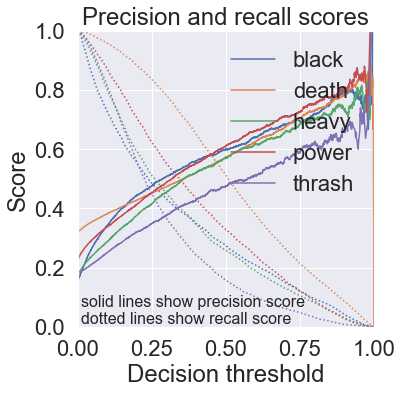

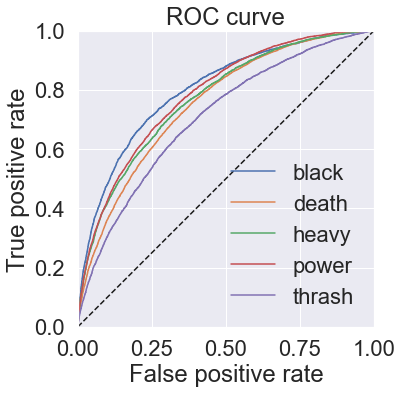

In [43]:
lstm_mlc = MultiLabelClassification(y_test, pred=lstm_pred, labels=labels)
lstm_mlc.print_report()
lstm_mlc.plot_precision_recall_curve()
lstm_mlc.plot_roc_curve()
lstm_mlc.best_thresholds()

In [44]:
lstm_mlc_tuned = MultiLabelClassification(y_test, pred=lstm_pred, labels=labels, threshold=lstm_mlc.best_thresholds())
lstm_mlc_tuned.print_report()


Average binary classification scores:
  balanced_accuracy   0.70 +/- 0.05
  precision           0.38 +/- 0.14
  recall              0.69 +/- 0.05
  f1                  0.49 +/- 0.12

Multi-label classification metrics:
  accuracy      0.38
  precision     0.41
  recall        0.71
  f1            0.52
  hamming loss  1.50

ROC AUC scores:
  black     : 0.802
  death     : 0.754
  heavy     : 0.772
  power     : 0.785
  thrash    : 0.707
  macro-avg : 0.764 +/- 0.033


In [45]:
lstm_pred.round().astype(int)[:20]

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [1, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 1, 1, 0]])

In [46]:
lstm_mlc_tuned.pred_class[:20]

array([[1, 1, 0, 0, 0],
       [1, 0, 1, 1, 0],
       [0, 0, 0, 1, 0],
       [1, 1, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [1, 1, 0, 0, 0],
       [1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 1, 1, 1],
       [0, 0, 1, 1, 1],
       [0, 0, 1, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 1, 0],
       [1, 1, 0, 0, 1],
       [1, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 1, 1, 0]])

In [47]:
y_test[:20]

array([[0, 0, 1, 1, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0]], dtype=int64)

### LSTM trained with sample weights

In [51]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [54]:
lstm_model_2 = Sequential()
lstm_model_2.add(embedding_layer)
lstm_model_2.add(layers.SpatialDropout1D(0.2))
lstm_model_2.add(layers.Bidirectional(layers.LSTM(128, return_sequences=False)))
lstm_model_2.add(layers.Dropout(0.2))
lstm_model_2.add(layers.BatchNormalization())
lstm_model_2.add(layers.Dense(num_labels, activation='sigmoid'))
opt = Adam(learning_rate=0.1)
lstm_model_2.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
print(lstm_model_2.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         9570000   
                                                                 
 spatial_dropout1d_2 (Spatia  (None, None, 100)        0         
 lDropout1D)                                                     
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              234496    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 batch_normalization_2 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                      

In [55]:
lstm_2_history = lstm_model_2.fit(
    padded_train,
    y_train,
    sample_weight=sample_weights,
    epochs=64,
    batch_size=32,
    callbacks=[early_stopping],
    validation_split=0.2,
    verbose=1
)
lstm_2_pred = lstm_model_2.predict(padded_test)
lstm_2_loss, lstm_2_acc = lstm_model_2.evaluate(padded_test, y_test, verbose=0)
print(f"loss: {lstm_2_loss:.4f}\nacc: {lstm_2_acc:.4f}")

Epoch 1/64
2580/2580 [==============================] - 152s 58ms/step - loss: 0.0291 - accuracy: 0.2020 - val_loss: 0.0270 - val_accuracy: 0.2774
Epoch 2/64
2580/2580 [==============================] - 147s 57ms/step - loss: nan - accuracy: 0.2433 - val_loss: nan - val_accuracy: 0.3233
Epoch 3/64
2580/2580 [==============================] - 147s 57ms/step - loss: nan - accuracy: 0.3176 - val_loss: nan - val_accuracy: 0.3233
Epoch 4/64
2580/2580 [==============================] - 159s 62ms/step - loss: nan - accuracy: 0.3176 - val_loss: nan - val_accuracy: 0.3233
Epoch 5/64
2580/2580 [==============================] - 162s 63ms/step - loss: nan - accuracy: 0.3176 - val_loss: nan - val_accuracy: 0.3233
Epoch 6/64
2580/2580 [==============================] - 172s 66ms/step - loss: nan - accuracy: 0.3176 - val_loss: nan - val_accuracy: 0.3233
Epoch 7/64
2580/2580 [==============================] - 173s 67ms/step - loss: nan - accuracy: 0.3176 - val_loss: nan - val_accuracy: 0.3233
Epoch 8

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
ax1.plot(lstm_2_history.history['accuracy'])
ax1.plot(lstm_2_history.history['val_accuracy'])
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'validation'], loc='upper left')
ax2.plot(lstm_2_history.history['loss'])
ax2.plot(lstm_2_history.history['val_loss'])
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
plt.show()

In [ ]:
lstm_2_mlc = MultiLabelClassification(y_test, pred=lstm_2_pred, labels=labels)
lstm_2_mlc.print_report()
lstm_2_mlc.plot_precision_recall_curve()
lstm_2_mlc.plot_roc_curve()
lstm_2_mlc.best_thresholds()

In [ ]:
lstm_2_mlc_tuned = MultiLabelClassification(y_test, pred=lstm_2_pred, labels=labels, threshold=lstm_2_mlc.best_thresholds())
lstm_2_mlc_tuned.print_report()

In [ ]:
lstm_2_pred.round().astype(int)[:20]

In [ ]:
lstm_2_mlc_tuned.pred_class[:20]

In [ ]:
y_test[:20]